In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from csv import DictWriter

import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances


from investigation_functions import  test_table_funcs as ttf
from investigation_functions import ml_funcs as mlf
from investigation_functions import ml_visualisation_funcs as mvf


## Functions and data gathering

In [18]:
n_qubits_list = [4,8,16]
backends_list = ['brisbane','torino','fez','marrakesh']
circuits_list = ['1','2','3']
exp_type_list = ['Hardware', 'Simulation','Refreshed_Simulation']


In [81]:
def get_test_list(
        qubits_list,change,
        backends_list = ['brisbane','torino','fez','marrakesh'],
        circuits_list = ['1','2','3'],
        exp_type_list = ['Hardware', 'Simulated','Refreshed_Simulated']
    ):
    
    backend_same =list(zip(backends_list,backends_list))
    circuit_same =list(zip(circuits_list,circuits_list))
    exp_type_same=list(zip(exp_type_list,exp_type_list))

    exp_type_pairs_ = exp_type_same
    circuit_pairs_ = circuit_same
    backend_pairs_ = backend_same

    if change == 'exp_type':
        exp_type_pairs_ =  list(combinations(exp_type_list, 2))
    elif change == 'circuits':
        circuit_pairs_ =  list(combinations(circuits_list, 2))
    elif change == 'backends':
        backend_pairs_ = list(combinations(backends_list, 2))
    else:
        raise('invalid change variable')
    

    test_combos = []

    
    for exp_type_pair in exp_type_pairs_:
    
        for nr_qubits in qubits_list:

            for circuit_pair in circuit_pairs_:

                for backend_pair in backend_pairs_:

                    row = {
                        'exp_type_pair':exp_type_pair,
                        'nr_qubits':nr_qubits,
                        'circuit_pair':circuit_pair,
                        'backend_pair':backend_pair
                    }
                    test_combos.append(row)
    
    return test_combos
def get_df_file_path_from_row(test_row, dir_runs, df_nr = 1,summarised = False):
    index = df_nr-1
    nq = str(test_row['nr_qubits'])
    exp_t =test_row['exp_type_pair'][index]
    circ = str(test_row['circuit_pair'][index])

    #get csv file_name
    file_name = nq + "q_"
    if exp_t =='Hardware':
        file_name = file_name +"ibm_"+test_row['backend_pair'][index]
    else:
        file_name = file_name +"fake_"+test_row['backend_pair'][index]
    if summarised:
        file_name = file_name +circ+"_summarised.csv"
    else:
        file_name = file_name +circ+".csv"

    #get file path
    file_path = dir_runs + exp_t +"_results/" 
    file_path = file_path+ nq+"q/"
    file_path = file_path + file_name

    return file_path


def load_test_dfs_from_test_row(test_row,dir_runs):
    df1_file_name = get_df_file_path_from_row(test_row,dir_runs,1)
    df2_file_name = get_df_file_path_from_row(test_row,dir_runs,2)

    df1 = pd.read_csv(df1_file_name)
    df2 = pd.read_csv(df2_file_name)

    return df1,df2

def load_summarised_test_dfs_from_test_row(test_row,dir_runs):
    df1_file_name = get_df_file_path_from_row(test_row,dir_runs,1,summarised=True)
    df2_file_name = get_df_file_path_from_row(test_row,dir_runs,2,summarised=True)

    df1 = pd.read_csv(df1_file_name)
    df2 = pd.read_csv(df2_file_name)
    return df1,df2

def get_and_record_corr_from_test_row(test_row, file_name,dir_corr,dir_runs):
    df1,df2 = load_test_dfs_from_test_row(test_row,dir_runs)
    corr_avg = df1.corrwith(df2).mean()
    
    fields = [
        "nr_qubits","exp_type 1","exp_type 2",
        "backend 1","backend 2","circuit 1","circuit 2",
        "corr avg"
    ]
    
    row = {
        "nr_qubits":test_row['nr_qubits'],
        "exp_type 1":test_row['exp_type_pair'][0],
        "exp_type 2":test_row['exp_type_pair'][1],
        "backend 1":test_row['backend_pair'][0],
        "backend 2":test_row['backend_pair'][1],
        "circuit 1":test_row['circuit_pair'][0],
        "circuit 2":test_row['circuit_pair'][1],
        "corr avg":corr_avg
    }
    with open(dir_corr+file_name, 'a', newline='') as f:
        writer = DictWriter(f, fieldnames=fields)
        writer.writerow(row)


def create_corr_csv(file_name,dir_corr):
    fields = [
        "nr_qubits","exp_type 1","exp_type 2",
        "backend 1","backend 2","circuit 1","circuit 2",
        "corr avg","cosine d","manhatt d","mse","euclidean d"
    ]
    with open(dir_corr+file_name, 'w', newline='') as f:
        writer = DictWriter(f, fieldnames=fields)
        writer.writeheader()

def get_and_record_corrs_from_tests_list(tests_list,file_name,dir_corr,dir_runs,create_csv = False):
    # fields = [
    #     "nr_qubits","exp_type 1","exp_type 2",
    #     "backend 1","backend 2","circuit 1","circuit 2",
    #     "corr avg"
    # ]
    if create_csv:
        create_corr_csv(file_name, dir_corr)
    
    for test_row in tests_list:
        get_and_record_corr_from_test_row(test_row,file_name,dir_corr,dir_runs)

def get_and_record_metrics_from_test_row(
        test_row, file_name,dir_corr,dir_runs,
        summarised = True,
        corrs =True,
        cosine_d = True,
        manhatt_d = True,
        norm_mse = True,
        euclidean_d = True
    ):
    df1,df2 = load_test_dfs_from_test_row(test_row,dir_runs)
    if not summarised:
        df1,df2 = load_test_dfs_from_test_row(test_row,dir_runs)
        cosine_d = False
        manhatt_d = False
        norm_mse = False
        euclidean_d = False
        corr_avg = df1.corrwith(df2,axis =1).mean() if corrs else None
    else:
        df1,df2 = load_summarised_test_dfs_from_test_row(test_row,dir_runs)
        corr_avg = df1.corrwith(df2,axis =1).mean() if corrs else None

    cos_d = cosine_distances(df1,df2) if cosine_d else None
    manh_d = norm_manhatt_dist(df1,df2) if manhatt_d else None
    mse = normalized_mse(df1,df2) if norm_mse else None
    euc_d = norm_eucclidean_dist if euclidean_d else None

    fields = [
        "nr_qubits","exp_type 1","exp_type 2",
        "backend 1","backend 2","circuit 1","circuit 2",
        "corr avg","cosine d","manhatt d","mse","euclidean d"
    ]
    
    row = {
        "nr_qubits":test_row['nr_qubits'],
        "exp_type 1":test_row['exp_type_pair'][0],
        "exp_type 2":test_row['exp_type_pair'][1],
        "backend 1":test_row['backend_pair'][0],
        "backend 2":test_row['backend_pair'][1],
        "circuit 1":test_row['circuit_pair'][0],
        "circuit 2":test_row['circuit_pair'][1],
        "corr avg":corr_avg,
        "cosine d":cos_d,
        "manhatt d":manh_d,
        "mse":mse,
        "euclidean d":euc_d
    
    }
    with open(dir_corr+file_name, 'a', newline='') as f:
        writer = DictWriter(f, fieldnames=fields)
        writer.writerow(row)

def get_and_record_metrics_from_tests_list(
        tests_list,file_name,dir_corr,dir_runs,create_csv = False,
        corrs =True,
        cosine_d = True,
        manhatt_d = True,
        norm_mse = True,
        euclidean_d = True
        ):
    if create_csv:
        create_corr_csv(file_name, dir_corr)
    
    for test_row in tests_list:
        get_and_record_metrics_from_test_row(
            test_row,file_name,dir_corr,dir_runs,
            corrs,
            cosine_d,
            manhatt_d,
            norm_mse,
            euclidean_d
        )
            

def rms(arr):
    rms_ = np.sqrt(np.mean(np.square(arr)))
    return rms_

def normalize_vector(vector):
    norm = np.linalg.norm(vector)
    return vector / norm if norm != 0 else vector

def normalized_mse(x1,x2):
    #https://www.mathworks.com/help/comm/ug/normalized-mean-square-distance-measure.html
    mse = mean_squared_error(x1, x2)
    denom = (x1.apply(lambda x: x**2)).mean()
    n_mse = mse/denom
    return n_mse

def norm_eucclidean_dist(x1,x2):
    x1n = normalize_vector(x1)
    x2n = normalize_vector(x2)
    return np.linalg.norm(x1n - x2n)

def norm_manhatt_dist(x1,x2):
    x1n = normalize_vector(x1)
    x2n = normalize_vector(x2)
    return np.sum(np.abs(x1n - x2n))

In [77]:
df1 = pd.read_csv('../Hardware_results/4q/4q_ibm_brisbane1.csv')
df2 = pd.read_csv('../Hardware_results/4q/4q_ibm_brisbane2.csv')
df3 = pd.read_csv('../Hardware_results/4q/4q_ibm_marrakesh3.csv')
# corrs_ax0 = df1.corrwith(df2)
corrs_ax1 = df1.corrwith(df2, axis=1)
corrs3 = df1.corrwith(df3,axis =1)
print(corrs_ax1.mean())
print(corrs3.mean())

# print(rms(corrs_ax1))
# print(rms(corrs3))

0.9999245367222582
0.9950092904336223


In [78]:

# df1.fillna(0,inplace=True)
# df2.fillna(0,inplace=True)
# df3.fillna(0,inplace=True)
# # print(mean_squared_error(df1, df2,multioutput='raw_values')/4096)
# # print(mean_squared_error(df1/4096, df2/4096,multioutput='raw_values'))
# print(mean_squared_error(df1, df2)/(4096**2))
# print(mean_squared_error(df1.iloc[:50,:], df3)/(4096**2))
# print(mean_squared_error(df1, df2))
# print(mean_squared_error(df1.iloc[:50,:], df3))
# print(np.sqrt(mean_squared_error(df1, df2))/4096)
# print(np.sqrt(mean_squared_error(df1.iloc[:50,:], df3))/4096)

In [32]:
df_4q_bris1_summ =pd.read_csv('../Hardware_results/4q/4q_ibm_brisbane1_summarised.csv')
df_4q_bris2_summ =pd.read_csv('../Hardware_results/4q/4q_ibm_brisbane2_summarised.csv')
df_4q_marr1_summ =pd.read_csv('../Hardware_results/4q/4q_ibm_marrakesh1_summarised.csv')

df_4q_bris1_summ_mean = df_4q_bris1_summ['mean']
df_4q_bris2_summ_mean = df_4q_bris2_summ['mean']
df_4q_marr1_summ_mean = df_4q_marr1_summ['mean']

In [79]:
corr_b12 = df_4q_bris1_summ_mean.corr(df_4q_bris2_summ_mean)
corr_b1_m1 = df_4q_bris1_summ_mean.corr(df_4q_marr1_summ_mean)

# mse_b12 = mean_squared_error(df_4q_bris1_summ_mean/4096,df_4q_bris2_summ_mean/4096)
# mse_b1_m1 = mean_squared_error(df_4q_bris1_summ_mean/4096,df_4q_marr1_summ_mean/4096)

print(corr_b12)
print(corr_b1_m1)
# print(mse_b12)
# print(mse_b1_m1)

0.9999889908235379
0.9544702600392905


#### Normalised Euclidean Distance
Apparently how you normalise euclidean distance is you normalise the vectors first: (https://stats.stackexchange.com/questions/136232/definition-of-normalized-euclidean-distance)

In [70]:

norm_b1 = normalize_vector(df_4q_bris1_summ_mean)
norm_b2 = normalize_vector(df_4q_bris2_summ_mean)
norm_marr1 = normalize_vector(df_4q_marr1_summ_mean)
norm_euc_b12 = np.linalg.norm(norm_b1 - norm_b2)
norm_euc_b1_m1= np.linalg.norm(norm_b1 - norm_marr1)
print(norm_euc_b12)
print(norm_euc_b1_m1)

0.004252885834243319
0.2715824385007603


#### Normalised MSE:

In [62]:
print(normalized_mse(df_4q_bris1_summ_mean,df_4q_bris2_summ_mean))
print(normalized_mse(df_4q_bris1_summ_mean,df_4q_marr1_summ_mean))

2.1500793663519576e-05
0.59935769938254


#### Cosine Distance
(sklearn does normalise)




https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html#sklearn.metrics.pairwise.cosine_similarity


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html

In [ ]:

print(cosine_distances([df_4q_bris1_summ_mean],[df_4q_bris2_summ_mean])[0][0])
print(cosine_distances([df_4q_bris1_summ_mean],[df_4q_marr1_summ_mean])[0][0])

9.043518959583885e-06
0.03687851045100965


#### Manhattan distances

Using normalised vectors to 'normalise' the manhattan distance


In [74]:
print(manhatt_dist(norm_b1,norm_b2))
# print(manhatt_dist(norm_b1,norm_b1))
print(manhatt_dist(norm_b1,norm_marr1))

0.013431583779471276
0.622880664441908


#### Results to CSV

In [ ]:
dir_corr = "../Fingerprint_results/all_metrics/"
file_name = "4q_bvb.csv"
dir_runs = "../"

qubits_list = [4]
# can change 'backends', 'circuits', 'exp type'
tests_list_bvb = get_test_list(qubits_list, change = 'backends')

get_and_record_metrics_from_tests_list(
    tests_list_bvb,file_name,dir_corr,dir_runs,create_csv=True
)

## Exp type plotting

In [21]:
df_4q_exp_t = pd.read_csv(dir_corr+"4q_exp_type.csv")
df_8q_exp_t = pd.read_csv(dir_corr+"8q_exp_type.csv")
df_16q_exp_t = pd.read_csv(dir_corr+"16q_exp_type.csv")

exp_type_dfs = [df_4q_exp_t,df_8q_exp_t,df_16q_exp_t] 

In [22]:
df_4q_exp_t.head(2)

,nr_qubits,exp_type 1,exp_type 2,backend 1,backend 2,circuit 1,circuit 2,corr avg
0,4,Hardware,Simulated,brisbane,brisbane,1,1,0.081313
1,4,Hardware,Simulated,torino,torino,1,1,-0.153477


In [23]:
def combine_cols(corr_df):
    new_df = corr_df

    exps = new_df.loc[:,'exp_type 1':'exp_type 2'].apply(np.unique,axis=1)
    new_df['exp types'] = exps.apply(" ".join)

    circs = new_df.loc[:,'circuit 1':'circuit 2'].astype(str)
    circs = circs.apply(np.unique,axis=1)
    new_df['circuits'] = circs.apply(" ".join)

    backs = new_df.loc[:,'backend 1':'backend 2'].apply(np.unique,axis=1)
    new_df['backends'] = backs.apply(" ".join)

    new_df.drop(
        [
            'exp_type 1','exp_type 2','circuit 1','circuit 2',
            'backend 1','backend 2'
        ],
        axis=1,inplace = True)

    return new_df
    # ", ".join(my_tuple)
def add_corr_mag(df):
    df_ = df
    df_['corr avg mag']=df_['corr avg'].apply(abs)
    return df

In [24]:
exp_dfs = []
for q in exp_type_dfs:
    newq =combine_cols(q)
    newq = add_corr_mag(newq)
    exp_dfs.append(newq)

In [25]:
exp_dfs[0].head(2)

,nr_qubits,corr avg,exp types,circuits,backends,corr avg mag
0,4,0.081313,Hardware Simulated,1,brisbane,0.081313
1,4,-0.153477,Hardware Simulated,1,torino,0.153477


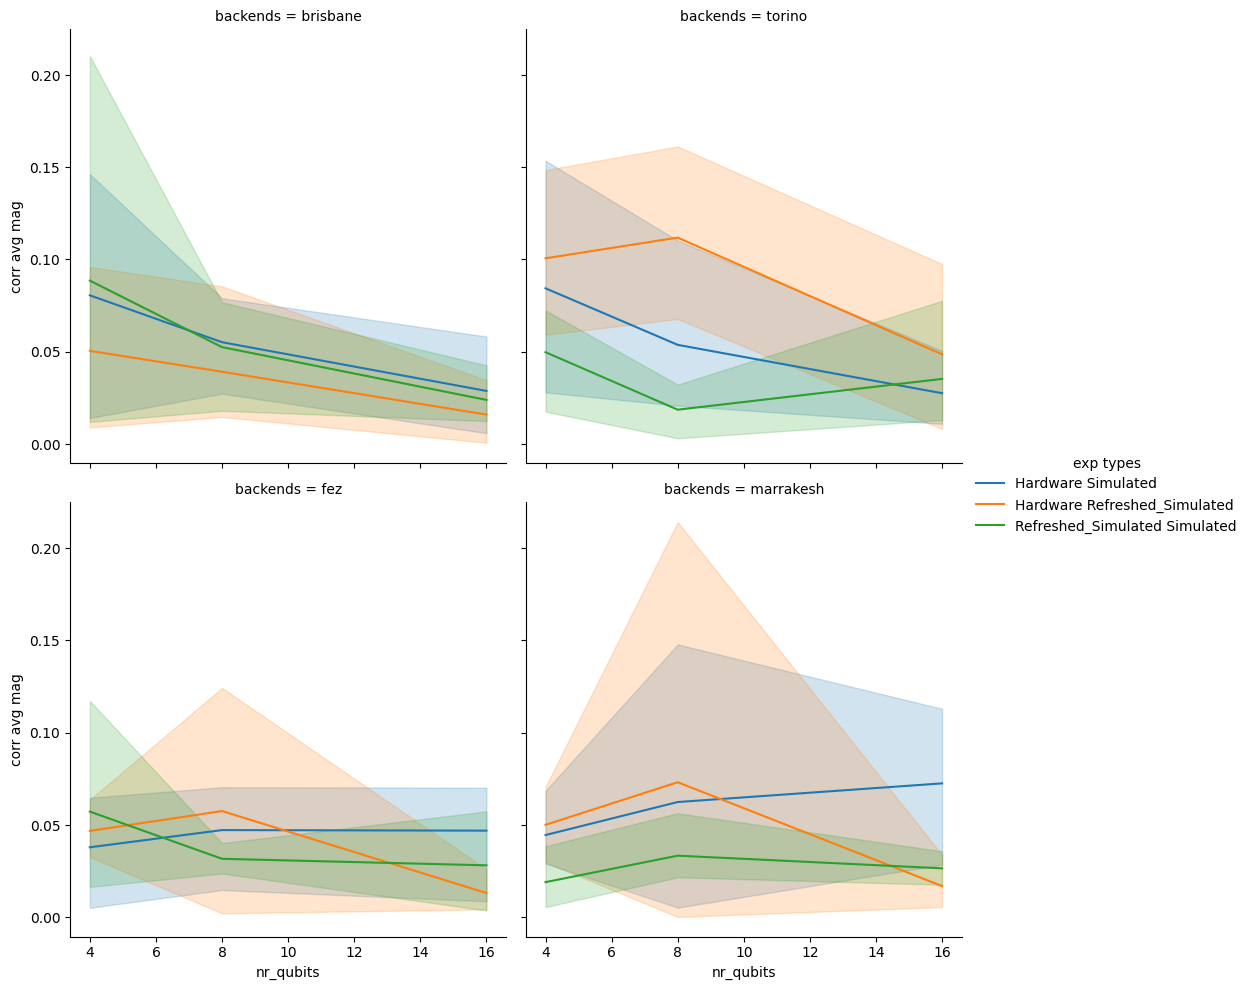

In [26]:
sns.relplot(
    data = pd.concat(exp_dfs),
    x= 'nr_qubits',
    y = 'corr avg mag',
    hue = 'exp types',
    col = 'backends',
    # row = 'circuits',
    kind = 'line',
    col_wrap = 2,
    height = 5,
    aspect = 1
)

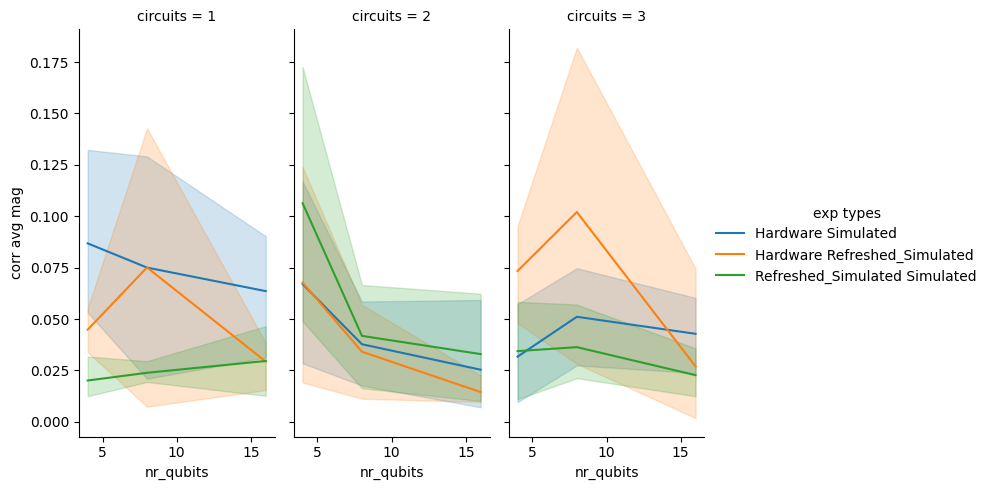

In [27]:
sns.relplot(
    data = pd.concat(exp_dfs),
    x= 'nr_qubits',
    y = 'corr avg mag',
    hue = 'exp types',
    # col = 'backends',
    col = 'circuits',
    kind = 'line',
    height = 5,
    aspect = 0.5
)

## Backend vs Backend plotting

In [28]:
df_4q_bvb = pd.read_csv(dir_corr+"4q_backends_vs_backends.csv")
df_8q_bvb = pd.read_csv(dir_corr+"8q_backends_vs_backends.csv")
df_16q_bvb = pd.read_csv(dir_corr+"16q_backends_vs_backends.csv")

bvb_dfs = [df_4q_bvb,df_8q_bvb,df_16q_bvb] 

bvb_dfs_p = []
for q in bvb_dfs:
    newq =combine_cols(q)
    newq = add_corr_mag(newq)
    bvb_dfs_p.append(newq)

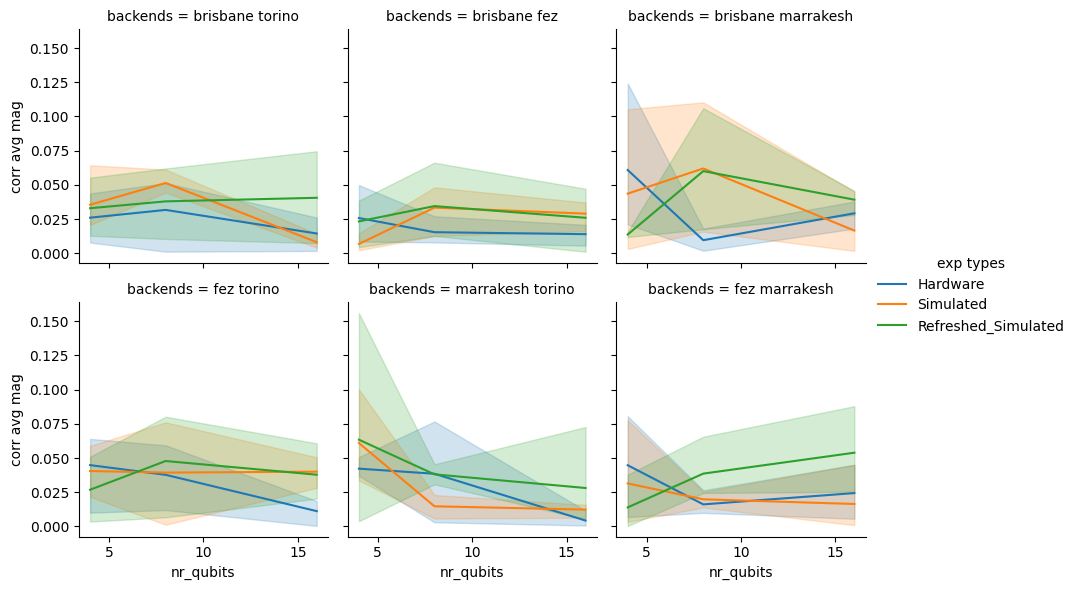

In [29]:
sns.relplot(
    data = pd.concat(bvb_dfs_p),
    x= 'nr_qubits',
    y = 'corr avg mag',
    col = 'backends',
    col_wrap = 3,
    hue = 'exp types',
    # row = 'circuits',
    kind = 'line',
    height = 3,
    aspect = 1
)

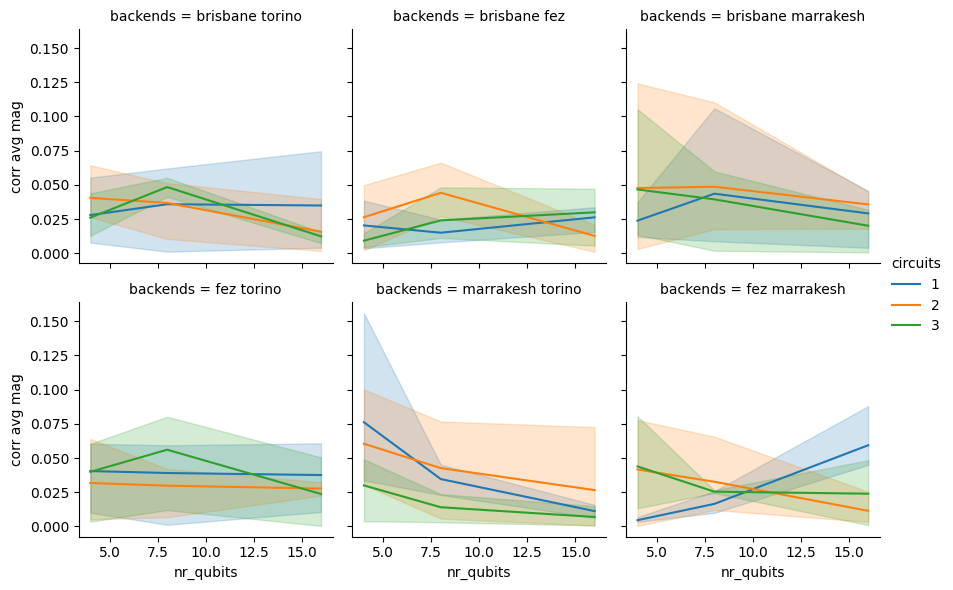

In [30]:
sns.relplot(
    data = pd.concat(bvb_dfs_p),
    x= 'nr_qubits',
    y = 'corr avg mag',
    col = 'backends',
    col_wrap = 3,
    # hue = 'exp types',
    hue = 'circuits',
    kind = 'line',
    height = 3,
    aspect = 1
)

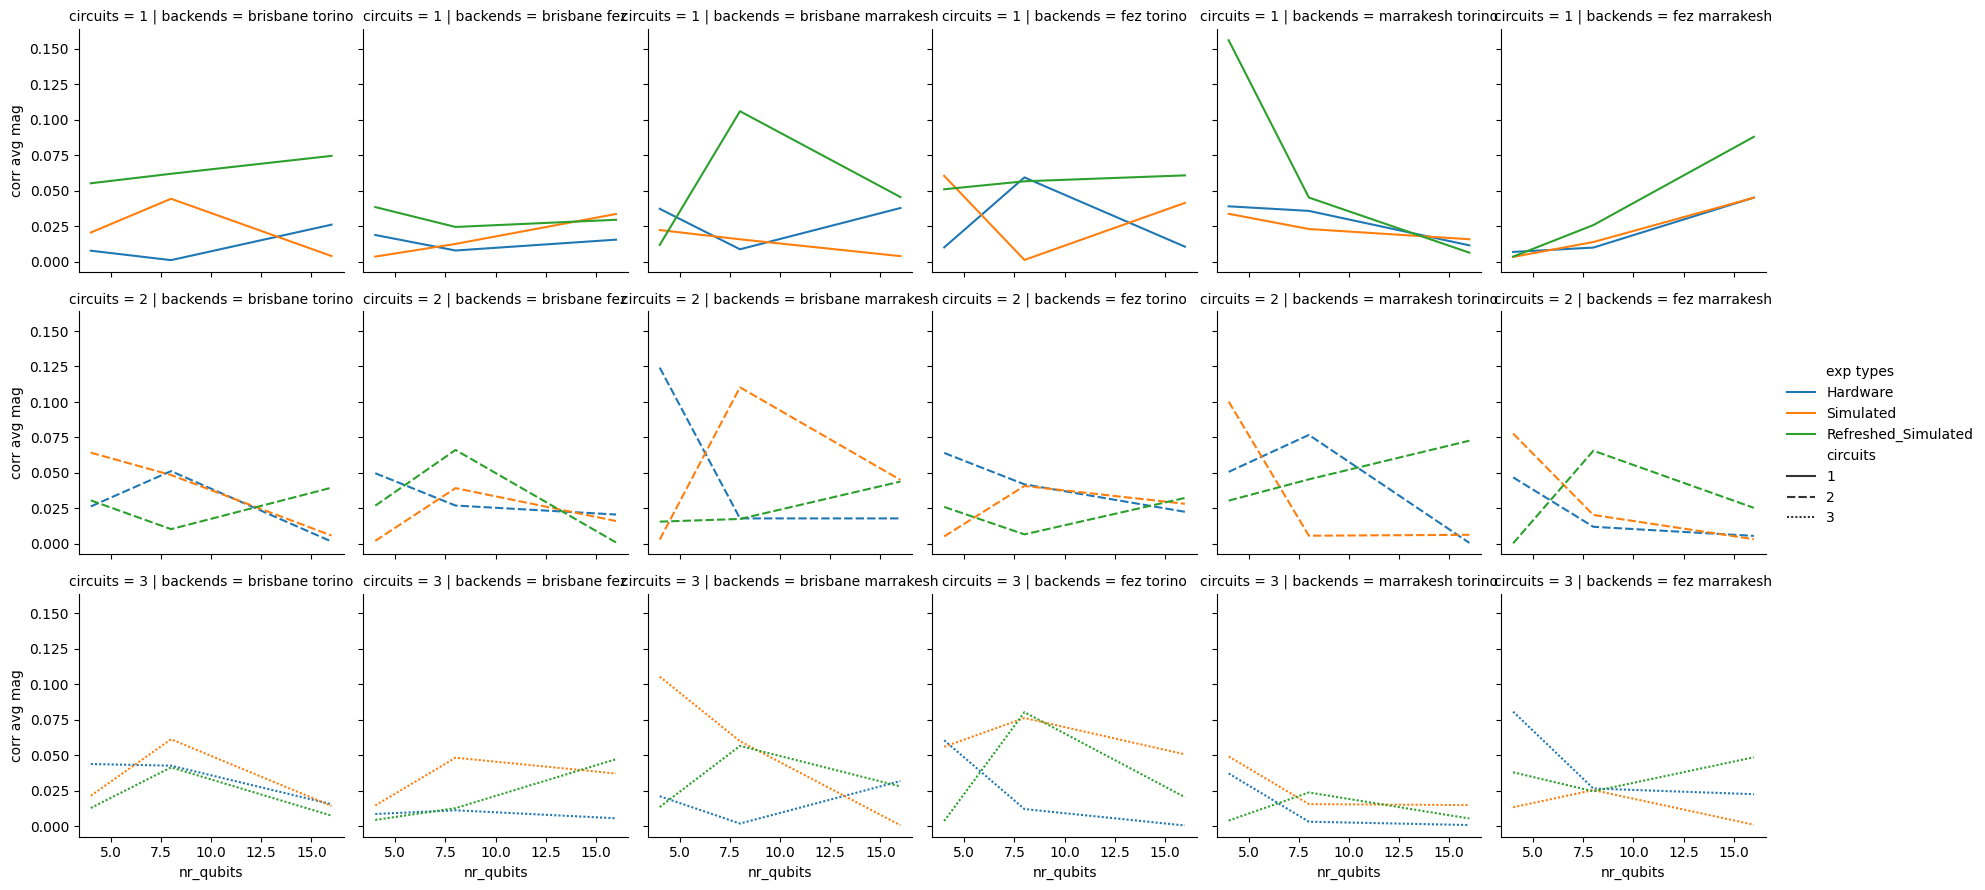

In [31]:
sns.relplot(
    data = pd.concat(bvb_dfs_p),
    x= 'nr_qubits',
    y = 'corr avg mag',
    col = 'backends',
    # col_wrap = 3,
    hue = 'exp types',
    style ='circuits',
    row = 'circuits',
    kind = 'line',
    height = 3,
    aspect = 1
)

Text(0.5, 1.05, 'Hardware Backend vs Backend Correlation Magnitudes')

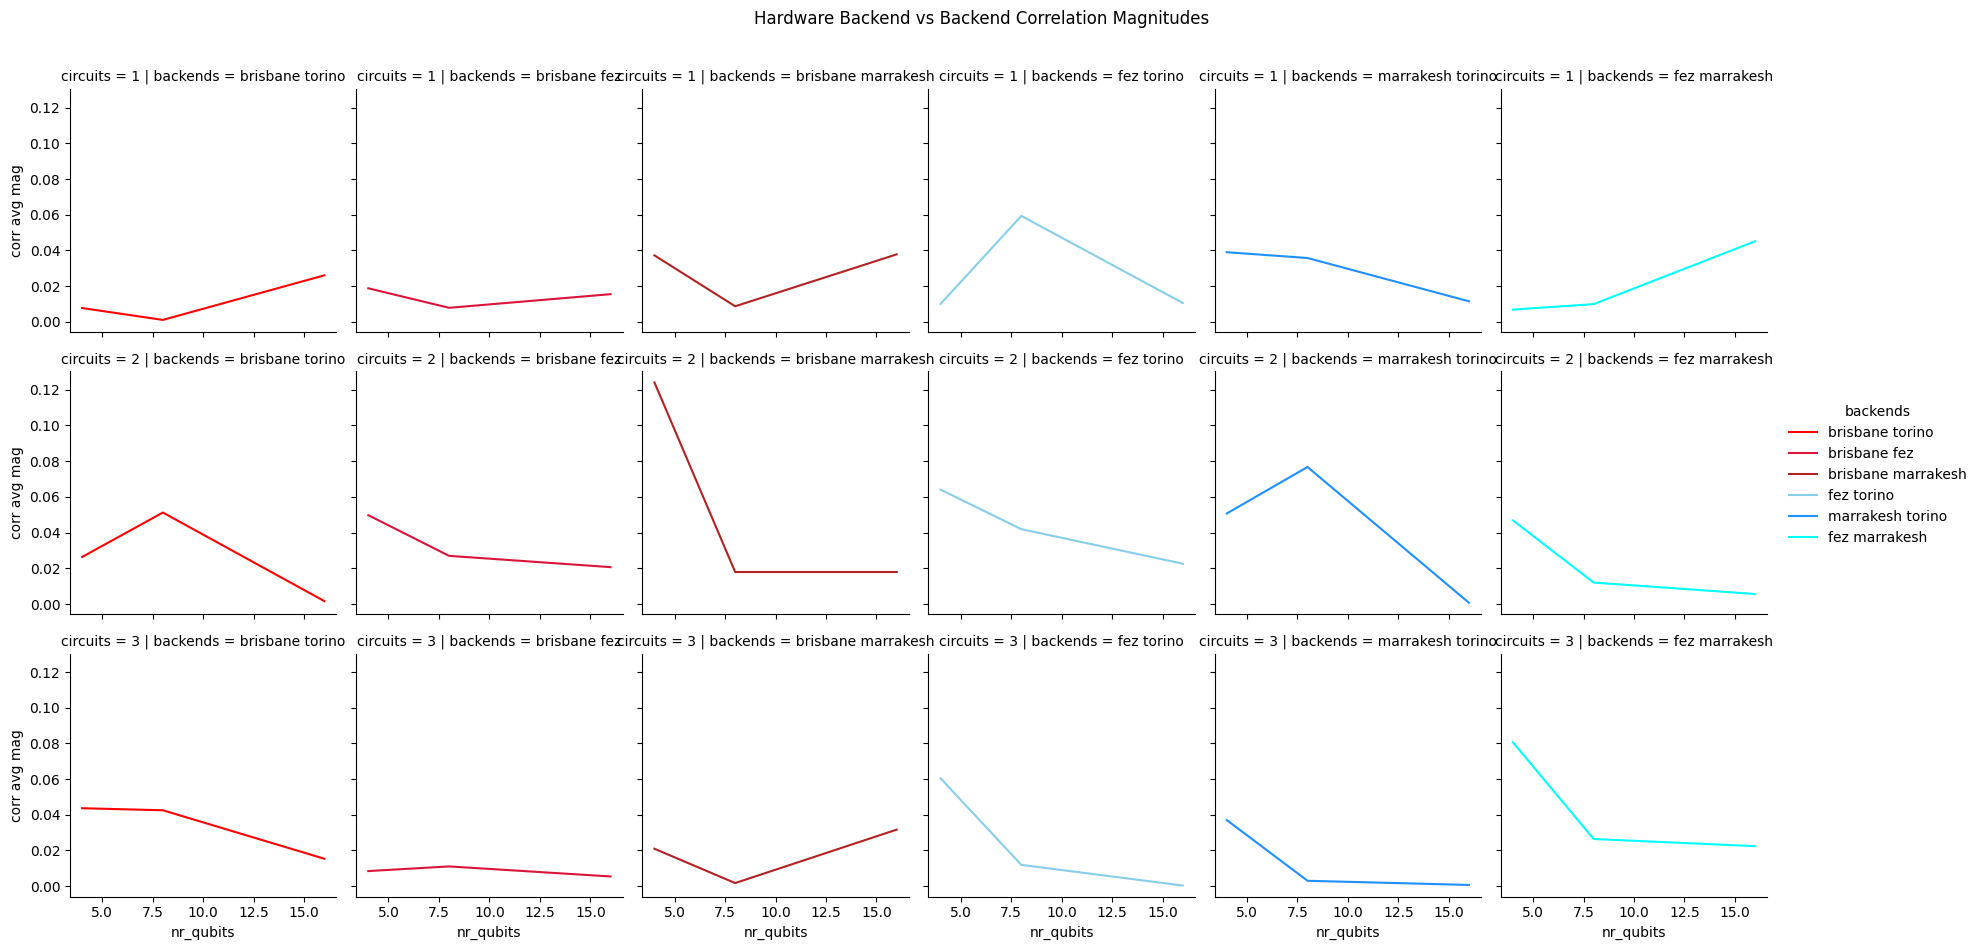

In [61]:
import matplotlib.colors as mcolors
all_bvb_p =pd.concat(bvb_dfs_p)
# ['exp types']

ax=sns.relplot(
    data = all_bvb_p[all_bvb_p['exp types']=='Hardware'],
    x= 'nr_qubits',
    y = 'corr avg mag',
    # col = 'exp types',
    # col_wrap = 3,
    row = 'circuits',
    col = 'backends',
    hue = 'backends',
    kind = 'line',
    height = 3,
    aspect = 1,
    # palette =sns.diverging_palette(220, 20)
    palette=sns.color_palette(
        palette = ['red','crimson','firebrick','skyblue','dodgerblue','cyan'])
)
plt.suptitle('Hardware Backend vs Backend Correlation Magnitudes',y = 1.05)

## Circuits vs Circuits

In [32]:
df_4q_cvc = pd.read_csv(dir_corr+"4q_circuits_table.csv")
df_8q_cvc = pd.read_csv(dir_corr+"8q_circuits_table.csv")
df_16q_cvc = pd.read_csv(dir_corr+"16q_circuits_table.csv")

cvc_dfs = [df_4q_cvc,df_8q_cvc,df_16q_cvc] 

cvc_dfs_p = []
for q in cvc_dfs:
    newq =combine_cols(q)
    newq = add_corr_mag(newq)
    cvc_dfs_p.append(newq)

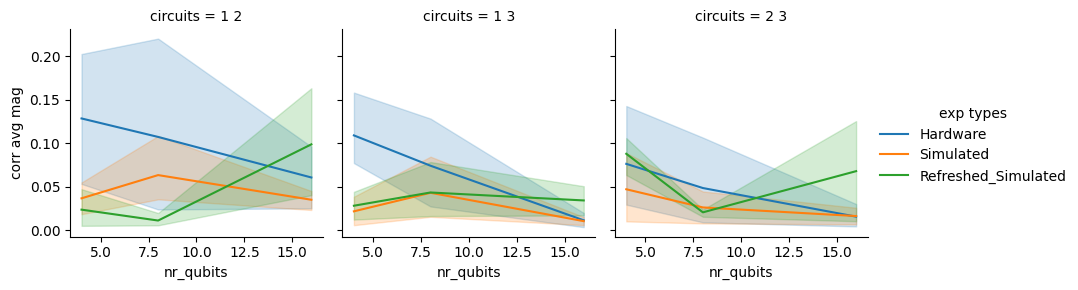

In [33]:
sns.relplot(
    data = pd.concat(cvc_dfs_p),
    x= 'nr_qubits',
    y = 'corr avg mag',
    # col = 'backends',
    col_wrap = 3,
    hue = 'exp types',
    col = 'circuits',
    kind = 'line',
    height = 3,
    aspect = 1
)

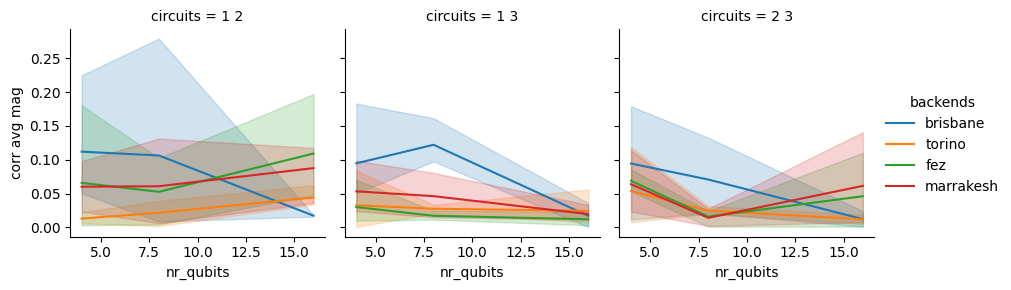

In [34]:
sns.relplot(
    data = pd.concat(cvc_dfs_p),
    x= 'nr_qubits',
    y = 'corr avg mag',
    # col = 'backends',
    col_wrap = 3,
    hue = 'backends',
    col = 'circuits',
    kind = 'line',
    height = 3,
    aspect = 1
)

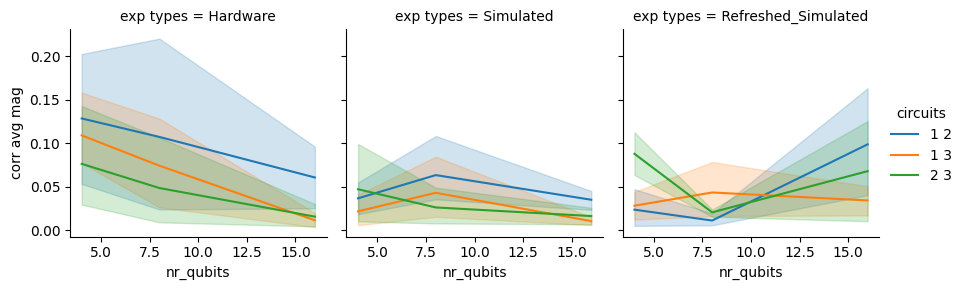

In [37]:
sns.relplot(
    data = pd.concat(cvc_dfs_p),
    x= 'nr_qubits',
    y = 'corr avg mag',
    # row = 'backends',
    # col_wrap = 3,
    col = 'exp types',
    hue = 'circuits',
    kind = 'line',
    height = 3,
    aspect = 1
)

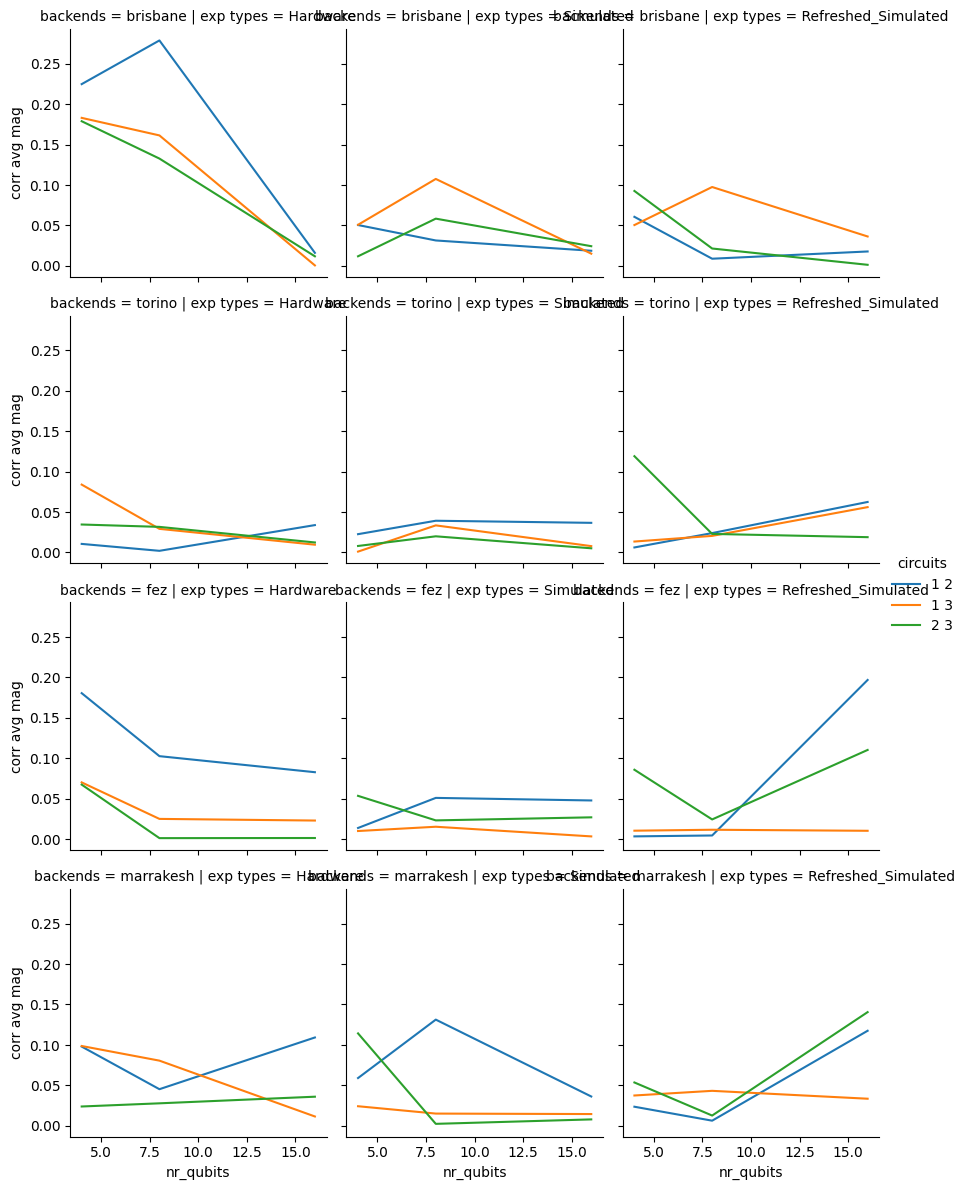

In [36]:
sns.relplot(
    data = pd.concat(cvc_dfs_p),
    x= 'nr_qubits',
    y = 'corr avg mag',
    row = 'backends',
    # col_wrap = 3,
    col = 'exp types',
    hue = 'circuits',
    kind = 'line',
    height = 3,
    aspect = 1
)